In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

sns.set(color_codes=True)

import torch
import torch.distributions as dst

%matplotlib inline

# Statistics

## Definition

<b>Statistics</b> is the discipline that concerns the collection, organization, displaying, analysis, interpretation and presentation of data <i>(Wikipedia)</i>.

In statistics and probability we usually consider two main concepts:<br />
1) <b>Sample Data</b> - The data we work with (usually, some numerical values). <br />
2) <b>Data Generating Process</b> - Some abstract or concrete process that we assume have generated our data. Often we describe such process with probability distribution or some parametric family of probability distributions (e.g Benoulli with potential parameter $p\in[0.4, 0.7]$). <br /><br />
Examples:<br />
100 coin flip results generated from flipping fair coin (Bernoulli(p=0.5))<br />
Heights of 500 individuals from population of Georgian citizens.<br />
10000 Celebrity faces from all the celebrity face pictures over the Internet.<br />
....

## Probability VS Statistics

<img src='images/stats/stats-vs-prob.png' style='height: 200px'>
<br />
<p><big>
    Given a <b>data generating process (e.g. probability distribution)</b> with known parameters, the goal of <b>probability</b> is to make statements about data to be observed.
</big></p>
<ul><li>What is the probability of observing heads in case of flipping fair coin?</li></ul>
<p><big>
    Given a <b>sample data</b>, the goal of <b>Statistics</b> is to make statements about the <b>unknown properties</b> of the underlying <b>data generating process</b>.
</big></p>
<ul><li>Given 100 coin flip results, what's the bias of the coin (is coin fair)?</li>
</ul>

### Machine Learning

Machine learning is closely related to Statistics. ML can be seen as a bunch of computer algorithms for learning data generating process properties from the data.

## Gaussian Distribution & Basic Concepts

Gaussian Distribution is a continous probability distribution which has a PDF of following form:

$f(x \mid \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2} } e^{ -\frac{(x-\mu)^2}{2\sigma^2} }
$

parameters of the distribution are:

$\mu$ - is a mean (a.k.a. center) of the distribution.<br />
$\sigma^2$ - is a variance of the distribution.

Gaussian with zero mean and unit variance is usually called <b>standard normal<b/> distribution.

Below is the visualization of the PDF with different parameters:

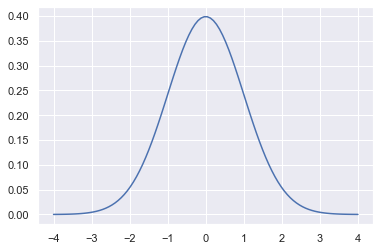

In [11]:
def create_gaussian_pdf(mu, sigma):
    
    return lambda x: 1 / np.sqrt(2 * np.pi * sigma ** 2) * np.exp(- (x - mu) ** 2 / (2 * sigma ** 2))

def plot_dist(pdf):
    
    x = np.linspace(-4, 4, num=100)
    y = pdf(x)

    plt.plot(x, y)
    
plot_dist(create_gaussian_pdf(0, 1))

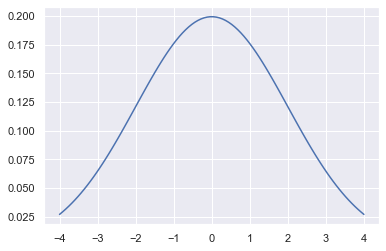

In [12]:
plot_dist(create_gaussian_pdf(0, 2))

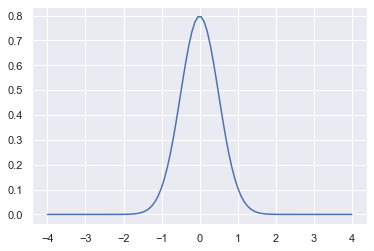

In [13]:
plot_dist(create_gaussian_pdf(0, 0.5))

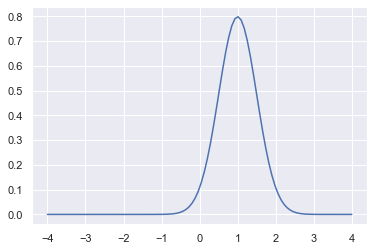

In [14]:
plot_dist(create_gaussian_pdf(1, 0.5))

### Central Limit Theoreom

Let, $X_{1}, X_{2}, ..., X_{N}$ be <b>iid (identically and independently distributed)</b> random variables with the mean ( $\operatorname{E}[X_{i}]=\mu$ ) and finite variance ( $Var[X_{i}]=\sigma^2<\infty$ )

Let, $S_n := \frac{X_1+\cdots+X_n}{n}$ be a sample mean (which itself is a random variable)

<br />

<b>Theorem (CLT):</b><br />
As $n\rightarrow{\infty}$, 
$\sqrt{n}\left(S_n - \mu\right)\ \xrightarrow{d}\ N\left(0,\sigma^2\right)$

or, equivalently

$\frac{\sqrt{n}}{\sigma}\left(S_n - \mu\right)\ \xrightarrow{d}\ N\left(0,1\right)$


<br />

Let's visualize the result of this theorem on coin flip example:

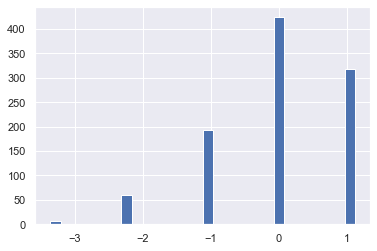

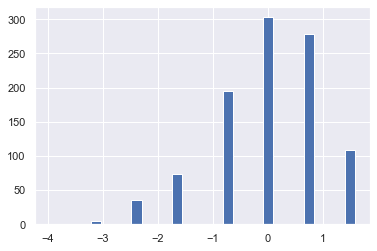

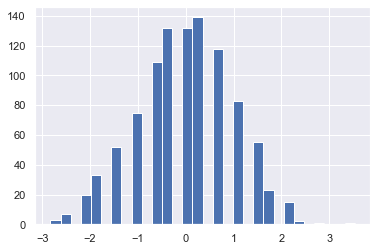

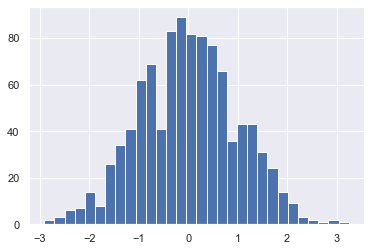

In [29]:
def sample_bernoulli(p):
    return int(np.random.rand() < p)

def generate_bernoulli_sample(p, sample_size):
    
    return [sample_bernoulli(p) for _ in range(sample_size)]

def sample_sn(p, n):
    
    return np.mean(generate_bernoulli_sample(p, n))

def scale(x, n, mu, sigma):
    
    return np.sqrt(n) * (x - mu) / sigma

# plotting sample mean distribution for different sample sizes.
p = 0.8
for n in [5, 10, 50, 500]:
    plt.hist([scale(sample_sn(p, n=n), n, p, np.sqrt(p * (1 - p))) for _ in range(1000)], bins=30)
    plt.show()

Now, let's perform same vizualization experiment with Exponential random variables.

Recall that exponential random variable is continous random variable with PDF:

$f(x;\lambda) = \begin{cases}
\lambda e^{-\lambda x} & x \ge 0, \\
0 & x < 0.
\end{cases}$

$\operatorname{E}[X]=\frac{1}{\lambda}$<br />
$\operatorname{Var}[X]=\frac{1}{\lambda^2}$

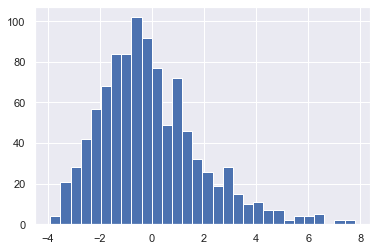

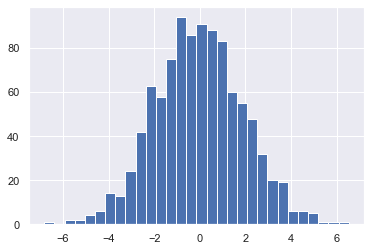

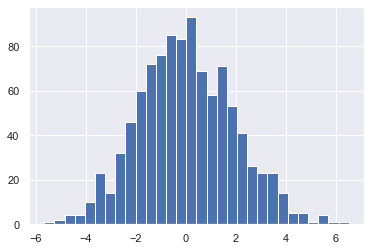

In [7]:
# same visualizations but not for Exponential random variable with parameter lambda=2 

def generate_exponential_sample(l, sample_size):
    dist = torch.distributions.Exponential(l)
    return [dist.sample().item() for _ in range(sample_size)]

def sample_sn(p, n):
    
    return np.mean(generate_exponential_sample(p, n))

def scale(x, n, mu, sigma):
    
    return np.sqrt(n) * (x - mu) / sigma

# plotting sample mean distribution for different sample sizes.
for n in [5, 100, 500]:
    plt.hist([scale(sample_sn(2, n=n), n, 1/2, 1/4) for _ in range(1000)], bins=30)
    plt.show()

## Application of CLT - Asymptotic Confidence Intervals

In statistics, confidence intervals are used to measure the "quality of estimation".

Let's say we have iid sample $X_{1}, X_{2}, ..., X_{n} \sim Bernoulli(p)$ with some unknown $p$.

We want to estimate unknown $p$ by using empirical average $\overline{X}_n=\sum_{k=1}^n X_k$<br /> (by the low of large numbers $\overline{X}_n\ \xrightarrow{P}\ \mu \qquad\textrm{when}\ n \to \infty$)

After calculating empirical average, we want to compute <b>confidence interval of level $1-\alpha$</b> for our estimator. Mathematically, we want to calculate interval $I$ from our data, so that $\lim_{n\to\infty} P(\overline{X}_n\in I)= 1-\alpha$

(Note that, confidence interval $I$ is itself a random variable and is calculated solely from the data.)

In this usecase, we will be using confidence interval centered around empirical average of form $[\overline{X}_n-s; \overline{X}_n+s]$ with some $s>0$.

We have,<br />
$\lim_{n\to\infty}P(p\in [\overline{X}_n-s; \overline{X}_n+s])= 1-\alpha$<br />
$\lim_{n\to\infty}P(\overline{X}_n-s\le p \le \overline{X}_n+s)= 1-\alpha$<br />
$\lim_{n\to\infty}P(|\overline{X}_n-p|\le s)= 1-\alpha$<br />
$\lim_{n\to\infty}P(\frac{\sqrt{n}}{\sigma}|\overline{X}_n-p|\le \frac{\sqrt{n}}{\sigma} s)= 1-\alpha$<br />
$\lim_{n\to\infty}P(|Z|\le \frac{\sqrt{n}}{\sigma} s)= 1-\alpha, \qquad Z\sim N(0, 1)$<br />

Note that, $P(|Z|\le t)=CDF(t)-CDF(-t)=CDF(t)-(1-CDF(t))=2CDF(t)-1=\alpha$<br />
$CDF(t)=1-\frac{1}{\alpha}$<br />
$t = Q(1-\frac{\alpha}{2})=q_{\frac{\alpha}{2}}$, where $Q$ is quantile function of standard gaussian.<br />

From above, if  $t=\frac{\sqrt{n}}{\sigma} s$, $s=\frac{\sigma}{\sqrt{n}} t=\frac{\sigma}{\sqrt{n}}q_{\frac{\alpha}{2}}$<br />

Finally, by substituting we get<br />
$\lim_{n\to\infty}P(p\in [\overline{X}_n-\frac{\sigma}{\sqrt{n}}q_{\frac{\alpha}{2}}; \overline{X}_n+\frac{\sigma}{\sqrt{n}}q_{\frac{\alpha}{2}}])= 1-\alpha$, where $\sigma^2=p(1-p)\approx \overline{X}_n(1-\overline{X}_n)$

In [47]:
x = generate_bernoulli_sample(0.5, sample_size=5000)
x[:20]

[0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1]

In [48]:
def bern_conf_interval(x, n, alpha):
    """Calculate asymptotic confidence interval of level 1-alpha for Bernoulli parameter p."""
    
    avg = np.mean(x)
    
    # can also use torch.distributions.Normal(0, 1).icdf()
    q = norm.ppf(1 - alpha / 2)

    s = np.sqrt(avg * (1 - avg) / n) * q
    
    return [avg - s, avg + s]

I = bern_conf_interval(x, 100, 0.05)
I

[0.40320208300821747, 0.5991979169917825]

In [55]:
# calculating the proportion of cases when true parameter falls within our confidence interval 

p = 0.5 # true mean of the distribution
alpha = 0.05 # confidence interval of level 95%

count = 0
for i in range(500):
    x = generate_bernoulli_sample(p, sample_size=500)
    I = bern_conf_interval(x, 500, alpha)
    if I[0] <= p <= I[1]:
        count += 1
        
count / 500

0.958

### Linear Regression Model (Theory)
<br /><br />
<b>Linear Regression</b> is one of the fundamental concepts in Machine Learning and Data Science. It is used when there is an assumption of <b>linear relationship</b> betweeen predictors/features $X_i$ and a dependent variable (label) $Y_i$

Examples:
<ul>
    <li>Predict human <b>height</b> $Y$ given features: <b>$X_1$ = Age</b>, <b>$X_2$ = Gender</b>, <b>$X_3$ = Father's height</b></li>
    <li>Predict <b>house price</b> $Y$ given features: <b>$X_1$ = Area</b>, <b>$X_2$ = # of bedrooms</b>, <b>$X_3$ = location</b>, <b>$X_3$ = # year built</b></li>
</ul>

In above cases, we assume that there are coefficients $\alpha, \beta, \gamma$, such that $Y \approx \alpha * X_1 + \beta * X_2 + \gamma * X_3$. Our goal is to find these coefficients.

<br /><br /><br />
<b>Task Formulation:</b><br /><br />
Lets, $(X_1, Y_1), (X_2, Y_2), ..., (X_{n}, Y_{n}) \overset{iid}{\sim} \mathbb{R}^d\times\mathbb{R}$ and the relationship between $X_{i}$ and $Y_{i}$ is given by linearity (with random noise)
$Y_{i}=\theta^TX_{i}+\epsilon_{i}$
<br /><br />
Lets also assume that $X_{i}\sim\mathcal{N}(0,\,I_d)$ and $\epsilon_i\sim\mathcal{N}(0,\,1)$
<br /><br />
Together with these assumptions, the above linearity is called <b>linear regression model</b> parametrized by vector $\theta\in\mathbb{R}^d$
<br /><br />
The above definitions imply that conditional density of $Y$ is defined as follows: $P_\theta(Y_{i}|x)=\mathcal{N}(\theta^Tx_{i}, 1)$
<br /><br />
Consequently, the data generating process can be thought as if we first sample $X$ from multivariate standard normal distribution and, afterwards, use above conditional density to sample corresponding $Y$
<br /><br /><br />
<b>The Maximum Likelihood Estimator for Linear Regression Model</b>

Generally, the true parameter $\theta$, that generated our observations, is unknown to us. Therefore, our goal is to find an estimate $\hat{\theta}$ from our data.

Method of <b>maximum likelihood estimation</b> tries to find estimator $\hat{\theta}_{MLE}$ so that our observed data becomes most probable under the assumed statistical model (data generating process) if we used $\hat{\theta}_{MLE}$ as a parameter. 

The probability of our observed data under a particular $\theta$ can be described as a function of $\theta$: $L(\theta)=\prod_{i=1}^{n} P_\theta(Y_{i}|x_i)$ 

Then, $\hat{\theta}_{MLE}=\underset{\theta\in\mathbb{R}^d}{\mathrm{argmax}} L(\theta)=\underset{\theta\in\mathbb{R}^d}{\mathrm{argmax}} \ln(L(\theta))$<br />
The latter is valid because $ln(x)$ is increazing function on its domain.
<br /><br />

$\ln{L(\theta)}=\sum_{i=1}^{n}\ln{\mathcal{N}(\theta^Tx_{i}, 1)}=\sum_{i=1}^{n}\ln{\frac{1}{\sqrt{2\pi\sigma^2} } exp( -\frac{(y_i-\theta^T x_i)^2}{2\sigma^2})}=\ln{\frac{n}{\sqrt{2\pi\sigma^2}}}-\frac{1}{2\sigma^2}\sum_{i=1}^n(y_i-\theta^T x_i)^2$<br /><br />
$\hat{\theta}_{MLE}=\underset{\theta\in\mathbb{R}^d}{\mathrm{argmax}} L(\theta)=\underset{\theta\in\mathbb{R}^d}{\mathrm{argmin}}\sum_{i=1}^n(y_i-\theta^T x_i)^2$<br />

NOTE 1: we end up optimizing something very similar to so called <b>Quadratic Loss</b> which is standard loss function used for training linear models in Machine Learning. <br />
NOTE 2: Optimization function is <b>convex</b> so there exists global unique minimizer.

# Some Concepts of Information Theory

In Statistics and Machine Learning there is often a requirement of having some kind of <b>distance</b> notion between probability distributions. In other words, we want to know how similar of different are two probability distributions and, moreover, we want to quantify this similarity.

<br /><br />
<b><big>Measure of Information Content</big></b>

Given some probability space $(\Omega, \mathcal{F}, P)$, let $A\subset \mathcal{F}$ is some event. <b>Information content / self-information / surprisal</b> of an event $A$ is defined as follows:<br /><br />
$I(A)=-logP(A)=log\frac{1}{P(A)}$<br /><br />
Based on the definition, information of event $A$ measures "how much unlikely" is event $A$, i.e "how much surprised" shall we be by observing $A$.<br /><br />
Examples:<br />
Let's assume we toss 6-sided fair dice and observe the outcome. Let's define events: A = {result <= 6}, B = {result is odd}, C = {result is 6}
<ul>
    <li>$I(A)=-log(1)=0$ - event $A$ has "no surprise" because we already knew that A is sure event. No information content</li>
    <li>$I(B)=-log(0.5)=1$ - event $B$ has "surpriseness"/"information content" of 1. We get some information - we can rule out that observation is even.</li>
    <li>$I(C)=-log(\frac{1}{6})\approx2.58$ - event $C$ has smallest probability so carries the most "surprise".</li>
</ul>

<b>Conclusion:</b> Rare events have high information content.<br /><br />

<b><big>Entropy</big></b>
<br /><br />
Let $p(X)$ be a probability mass function for some random variable $X$.

<b>Entropy</b> of a random variable $X$ is defined as an expectation of the information content of it's outcomes:<br /><br />
$H(X)=\mathbb{E}_p[I_p(X)]=-\sum_{i=1}^{n}p(x_i)logp(x_i)$   ($x_i$ are possible values of $X$)

In [22]:
def entropy(x):
    return -np.sum(x * np.log2(x))

def bar_plot(x):
    plt.bar(list(range(len(x))), x)

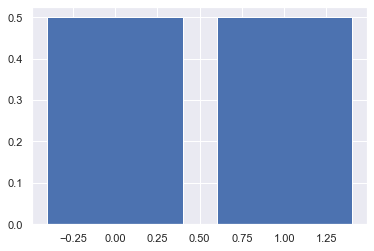

In [23]:
x = [0.5, 0.5]

bar_plot(x)

In [24]:
entropy(x)

1.0

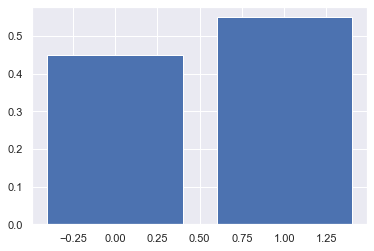

In [25]:
x = [0.45, 0.55]

bar_plot(x)

In [26]:
entropy(x)

0.9927744539878083

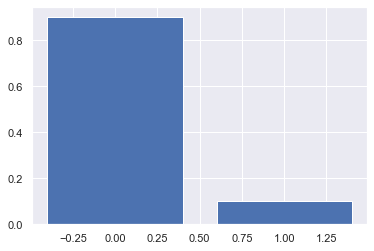

In [20]:
x = [0.9, 0.1]

bar_plot(x)

In [21]:
entropy(x)

0.4689955935892812

2.321928094887362

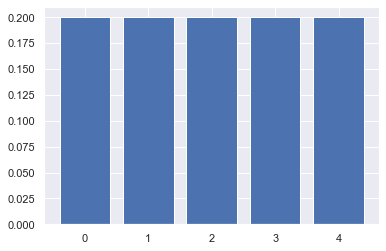

In [32]:
# entropy is maximal here because all outcomes are equiprobable - we don't know nothing which has high chance to come.

x = [0.2, 0.2, 0.2, 0.2, 0.2]

bar_plot(x)

entropy(x)

2.2464393446710154

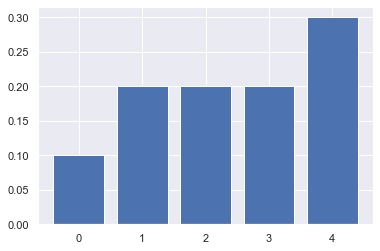

In [30]:
x = [0.1, 0.2, 0.2, 0.2, 0.3]

bar_plot(x)

entropy(x)

2.170950594454669

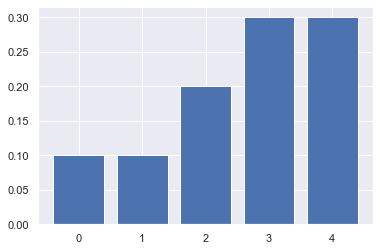

In [33]:
x = [0.1, 0.1, 0.2, 0.3, 0.3]

bar_plot(x)

entropy(x)

<b><big>Cross-Entropy</big></b>
<br /><br />
Let $p(X)$ and $q(X)$ be two probability mass functions over a same set of events.
<br /><br />
<b>Cross Entropy</b> between distributions $p$ and $q$ is defined as following expectation:<br /><br />
$H(p, q)=\mathbb{E}_p[I_q(X)]=-\sum_{i=1}^{n}p(x_i)logq(x_i)$   ($x_i$ are possible values of $X$)
<br /><br />

Note that, $p==q$ implies $H(p, q)=H(p)=H(q)$, i.e. cross-entropy becomes just entropy.

<br /><br />

Lets see examples:

In [34]:
def cross_entropy(p, q):
    return -np.sum(p * np.log2(q))

True

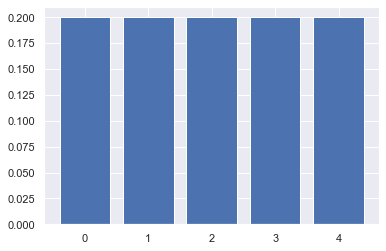

In [38]:
p = [0.2, 0.2, 0.2, 0.2, 0.2]

bar_plot(p)

cross_entropy(p, p) == entropy(p)

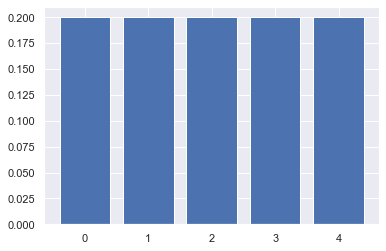

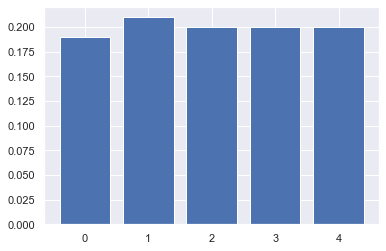

In [46]:
eps = 1e-2
p = [0.2, 0.2, 0.2, 0.2, 0.2]
q = [0.2-eps, 0.2+eps, 0.2, 0.2, 0.2]


bar_plot(p)
plt.show()
bar_plot(q)

In [47]:
abs(cross_entropy(p, q) - entropy(p))

0.0007222507104756026

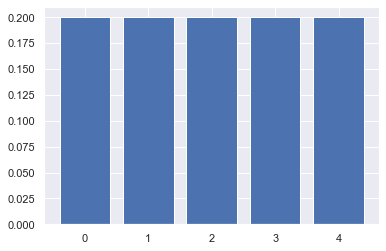

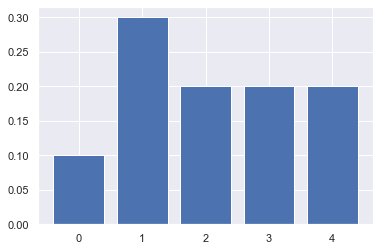

In [48]:
eps = 1e-1
p = [0.2, 0.2, 0.2, 0.2, 0.2]
q = [0.2-eps, 0.2+eps, 0.2, 0.2, 0.2]


bar_plot(p)
plt.show()
bar_plot(q)

In [49]:
abs(cross_entropy(p, q) - entropy(p))

0.08300749985576905

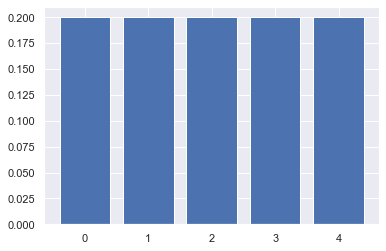

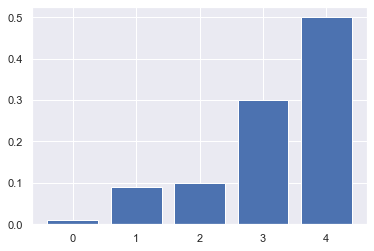

In [55]:
eps = 1e-2
p = [0.2, 0.2, 0.2, 0.2, 0.2]
q = [0.01, 0.09, 0.1, 0.3, 0.5]


bar_plot(p)
plt.show()
bar_plot(q)

In [56]:
abs(cross_entropy(p, q) - entropy(p))

0.9134081185447793

<b>Intuition:</b> Cross entropy of "similar" distributions is smaller, and for "dissimilar" - larger
<br /><br />
It can be thought as a distance measure between distributions, it isn't a valid metric though as shown below.

In [71]:
# H(p, q) != H(q, p)
cross_entropy(q, p) == cross_entropy(p, q)

False

Cross entropy has many applications in <b>Machine Learning</b>, for example, it is used to measure similarity between predictions and ground-truth labels (loss function).

<b><big>Kullback-Leibler (KL) Divergence</big></b>
<br /><br />
Let $p(X)$ and $q(X)$ be two probability mass functions over a same set of events.
<br /><br />
<b>Kullback-Leibler divergence</b> between distributions $p$ and $q$ is defined as following expectation:<br /><br />
$KL(p, q)=\mathbb{E}_p[log\frac{p(X)}{q(X)}]=\sum_{i=1}^{n}p(x_i)log\frac{p(x_i)}{q(x_i)}$   ($x_i$ are possible values of $X$)
<br /><br />

Note that, the above formula is valid where $q(x)\neq0$ or both $p(x)=q(x)=0$ Otherwise, $KL(p, q)=\infty$<br /><br />

Also, if $p=q$, $KL(p, q)=0$

<br /><br />

There is a relation between <b>Entropy</b>, <b>Cross-Entropy</b> and <b>KL divergence:</b><br /><br />
    
$H(p, q)=H(P)+KL(p, q)$   

<br /><br /> 

Some final notes:
<ul>
    <li>Similarly to Cross-Entropy, KL divergence is used in Statistics and Machine Learning to measure similarity between probability distributions.</li>
    <li>KL Divergence is used as a loss function in approximate variational inference - powerful unsupervised technique in ML to learn complex distributions</li>
    
</ul>